## About this notebook

**Prototyping pre-processing original images**

**Prototyping: CODE for preprocessing pipeline pipe003**

## Import libraries

In [1]:
import os
import glob
import re

import numpy as np 
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

## Config

In [2]:
class cfg: 
    #==================================================
    # THIS NOTEBOOK ID
    THIS_NOTEBOOK_REF = "FR_t01e01nb02v3" #pipe03
    
    #==================================================
    # ROOT DATA SOURCE
    ROOT_DATA = os.path.join('..', '..', '..', 
                             'data', 
                             '01_original', 
                             'IQ_OTHNCCD_LungCancer', 
                             'IQ_OTHNCCD')
    
    #==================================================
    # ROOT DATA SAVE
    ROOT_2SAVE = os.path.join('..', '..', '..', 
                              'data',
                             )


## Utility functions

### create_img_d_meta()

In [3]:
def create_img_d_meta(ROOT_DATA): 

    """
    Description: 
    ------------
        this function find all the images path and create a 
            pd.DataFrame() d_meta for easy filetering and 
            selection of the images for each experiment. 
            This function is optimize for this dataset IQ_OTHNCCD

    Pararmentter
    ------------
        ROOT_DATA: path where the image data is stored. 
                    Expected data structure within the ROOT directory
                    IQ_OTHNCCD
                        ├───Bengin cases
                        ├───Malignant cases
                        └───Normal cases


    Return: 
    --------
        d_meta: pd.DataFrame of metadata of images with columns : 
            'path', 'fname', 'img_n_order', 'cls_name', 'y_true
                col 'img_n_order' indicates the order of the image provided by the 
                                 data creators 

            map_dict use for y_true 
            map_dict = {'Normal cases': 0, 
                        'Bengin cases': 1, 
                        'Malignant cases': 2, 
                        }
        
    """

    #___________________________
    # Find all path 
    all_img_path_lst = glob.glob(os.path.join(ROOT_DATA, '*', '*.jpg'))

    #___________________________
    # adding meta to each image path. 
    store_d = []
    for p in all_img_path_lst:
    
        fname = os.path.split(p)[1]
        cls_name = os.path.split(os.path.split(p)[0])[1]
        img_n_order = int(re.findall(r'\((.*?)\)', fname)[0])

        #__________
        # Images in IQ_OTHNCCD are gray scale
        img = cv2.imread(filename=p, flags=0)
        original_shape = img.shape
    
        #------
        # Store data 
        store_d.append([p, 
                        fname, 
                        img_n_order, 
                        cls_name, 
                        original_shape,
                       ])
        #------
        #___________________________________________
        # break
    #_______________________________________________
    # Creating d_meta
    d_meta = pd.DataFrame(store_d, columns=["path_original", "fname", "img_n_order", "cls_name", "img_shape_original"])
    d_meta["img_shape_original"] = d_meta["img_shape_original"].apply(lambda x: f"{x[0]}x{x[1]}" if isinstance(x, tuple) else str(x))
    map_dict = {'Normal cases': 0, 
                'Bengin cases': 1, 
                'Malignant cases': 2
               }
    d_meta['cls_id'] = d_meta['cls_name'].map(map_dict)
    d_meta["img_ID"] = "cls" + d_meta['cls_id'].astype(str) + "_order" + d_meta["img_n_order"].astype(str)
    d_meta.sort_values(by=["cls_id", "img_n_order",], ignore_index=True, inplace=True)
    #_______________________________________________
    return d_meta


### apply_clahe()

In [4]:
def apply_clahe(image, clipLimit=2.0, tileGridSize=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    return clahe.apply(image)

### VIZ_CLAHE()

In [5]:
def VIZ_CLAHE(img_ID, d_meta, clipLimit=2.0, tileGridSize=(8, 8), ): 
    c1 = d_meta["img_ID"] == img_ID
    path = d_meta[c1]["path_original"].item()
    img1 = cv2.imread(filename=path, flags=0)
    
    # Apply CLAHE
    def apply_clahe(img, clipLimit=2.0, tileGridSize=(8, 8)):
        clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
        return clahe.apply(img)
    
    img2 = apply_clahe(img1, clipLimit=clipLimit, tileGridSize=tileGridSize)
    
    # Compute percentage histograms
    def calc_hist_percent(img):
        hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        return hist / hist.sum() * 100
    
    hist1 = calc_hist_percent(img1)
    hist2 = calc_hist_percent(img2)
    max_percent = max(hist1.max(), hist2.max()) * 1.05
    
    # Create a 4x2 grid
    fig = plt.figure(figsize=(7, 8))
    gs = GridSpec(4, 2, width_ratios=[1.5, 1])
    
    # Image 1: spans rows 0 and 1, column 0
    ax_img1 = fig.add_subplot(gs[0:2, 0])
    ax_img1.imshow(img1, cmap='gray', aspect='auto', vmin=0, vmax=255)
    ax_img1.set_title(f"ImgID: {img_ID}")
    ax_img1.axis('off')
    
    # Histogram 1: row 1, col 1
    ax_hist1 = fig.add_subplot(gs[1, 1])
    ax_hist1.plot(hist1, color='black')
    ax_hist1.set_title("Histogram 1 (Percentage)")
    ax_hist1.set_xlim([0, 256])
    ax_hist1.set_ylim([0, max_percent])
    ax_hist1.set_xlabel("Pixel Intensity", fontsize=9)
    ax_hist1.set_ylabel("Percentage (%)", fontsize=9)
    ax_hist1.grid(True)
    ax_hist1.tick_params(labelsize=8)
    ax_hist1.spines['top'].set_visible(False)
    ax_hist1.spines['right'].set_visible(False)
    
    # Image 2: spans rows 2 and 3, column 0
    ax_img2 = fig.add_subplot(gs[2:4, 0])
    ax_img2.imshow(img2, cmap='gray', aspect='auto', vmin=0, vmax=255)
    ax_img2.set_title(f"CLAHE: clipLimit={clipLimit} | tileGridSize={tileGridSize}")
    ax_img2.axis('off')
    
    # Histogram 2: row 3, col 1
    ax_hist2 = fig.add_subplot(gs[3, 1])
    ax_hist2.plot(hist2, color='black')
    ax_hist2.set_title("Histogram 2 (Percentage)")
    ax_hist2.set_xlim([0, 256])
    ax_hist2.set_ylim([0, max_percent])
    ax_hist2.set_xlabel("Pixel Intensity", fontsize=9)
    ax_hist2.set_ylabel("Percentage (%)", fontsize=9)
    ax_hist2.grid(True)
    ax_hist2.tick_params(labelsize=8)
    ax_hist2.spines['top'].set_visible(False)
    ax_hist2.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

## Create Meta

In [6]:
d_meta = create_img_d_meta(ROOT_DATA=cfg.ROOT_DATA)
d_meta.info()
d_meta.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   path_original       1097 non-null   object
 1   fname               1097 non-null   object
 2   img_n_order         1097 non-null   int64 
 3   cls_name            1097 non-null   object
 4   img_shape_original  1097 non-null   object
 5   cls_id              1097 non-null   int64 
 6   img_ID              1097 non-null   object
dtypes: int64(2), object(5)
memory usage: 60.1+ KB


,path_original,fname,img_n_order,cls_name,img_shape_original,cls_id,img_ID
0,../../../data/01_original/IQ_OTHNCCD_LungCance...,Normal case (1).jpg,1,Normal cases,512x512,0,cls0_order1
1,../../../data/01_original/IQ_OTHNCCD_LungCance...,Normal case (2).jpg,2,Normal cases,512x512,0,cls0_order2
2,../../../data/01_original/IQ_OTHNCCD_LungCance...,Normal case (3).jpg,3,Normal cases,512x512,0,cls0_order3


## VIZ - IMG

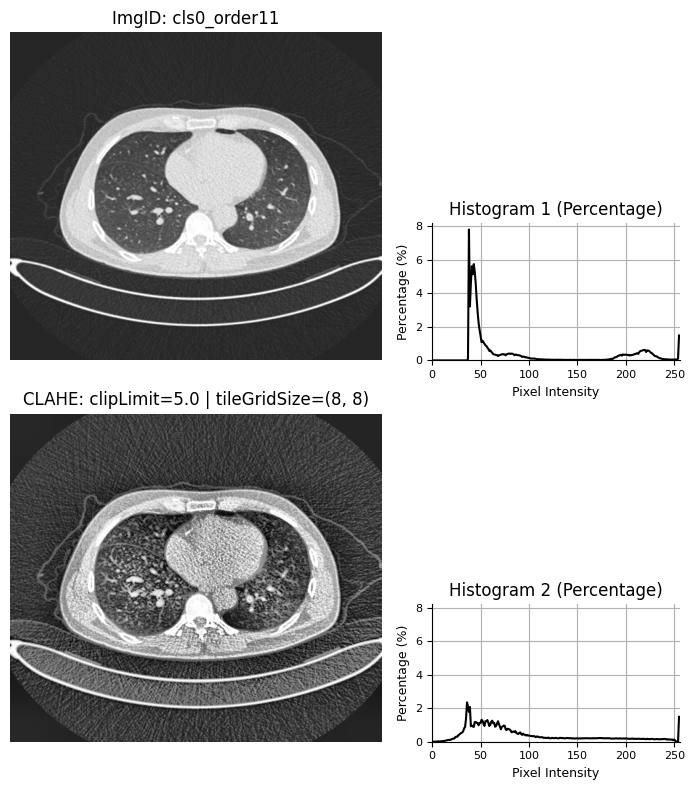

In [7]:
VIZ_CLAHE(img_ID="cls0_order11", d_meta=d_meta, clipLimit=5.0, tileGridSize=(8, 8))

## Pipe002

In [8]:
%%time

pipeID="pipe003"
img_size  = 256 # pixels 
img_size  = 256 # pixels 
clipLimit = 5.0
tileGridSize = (8,8)
pixel_norm = True

path2save_pipeID = os.path.join(cfg.ROOT_2SAVE, pipeID)


#________________________________________________________
# Create folder
os.makedirs(path2save_pipeID, exist_ok=True)


#________________________________________________________

store_meta_lst = []
for r_id, data in d_meta.iterrows(): 

    #______________________________________________________________
    # create class folder if needed 
    path = os.path.join(path2save_pipeID, f"{pipeID}_imgs", data["cls_name"])
    os.makedirs(path, exist_ok=True)

    #______________________________________________________________
    # pipe >> READ > Resize 
    img = cv2.imread(filename=data["path_original"], flags=0)
    img_resized = cv2.resize(img, (img_size, img_size)) # out_shape 256x256

    #______________________________________________________________
    # Apply CLAHE After Resizing > Looking for better stability across tile sizes.
    #    I want to reduce the risk of the model learning resulting pattern for changes 
    #      in Tile size due to diff img sizes.
    img_resized = apply_clahe(img_resized, clipLimit=clipLimit, tileGridSize=tileGridSize)


    #______________________________________________________________
    # Normalize pixels values
    if pixel_norm: 
        img_resized = img_resized/255.0

    #______________________________________________________________
    # Store 2D numpy array (image with 1 channel, gray scale)
    arr_name = f"{pipeID}_{data['img_ID']}_.npy"
    path_arr_name = os.path.join(path, arr_name)
    
    np.save(path_arr_name, img_resized)

    #______________________________________________________________
    store_meta_lst.append([
        data["path_original"],
        data["img_ID"], 
        path_arr_name,
        data["img_shape_original"],
        f"{img_size}x{img_size}",
        data["img_n_order"],
        data["cls_name"],
        data["cls_id"],
    ])

    #______________________________________________________________
    # break
#________________________

CPU times: user 7.03 s, sys: 9.46 s, total: 16.5 s
Wall time: 33 s


In [9]:
d_meta_DataPipe = pd.DataFrame(store_meta_lst,
                               columns= ["path_original_img", 
                                         "img_ID",
                                         f"path_img_{pipeID}",
                                         "img_shape_original",
                                         f"img_shape_{pipeID}",
                                         "img_n_order",
                                         "cls_name",
                                         "cls_id"]
                              )
d_meta_DataPipe.info()
d_meta_DataPipe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   path_original_img   1097 non-null   object
 1   img_ID              1097 non-null   object
 2   path_img_pipe003    1097 non-null   object
 3   img_shape_original  1097 non-null   object
 4   img_shape_pipe003   1097 non-null   object
 5   img_n_order         1097 non-null   int64 
 6   cls_name            1097 non-null   object
 7   cls_id              1097 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 68.7+ KB


,path_original_img,img_ID,path_img_pipe003,img_shape_original,img_shape_pipe003,img_n_order,cls_name,cls_id
0,../../../data/01_original/IQ_OTHNCCD_LungCance...,cls0_order1,../../../data/pipe003/pipe003_imgs/Normal case...,512x512,256x256,1,Normal cases,0
1,../../../data/01_original/IQ_OTHNCCD_LungCance...,cls0_order2,../../../data/pipe003/pipe003_imgs/Normal case...,512x512,256x256,2,Normal cases,0
2,../../../data/01_original/IQ_OTHNCCD_LungCance...,cls0_order3,../../../data/pipe003/pipe003_imgs/Normal case...,512x512,256x256,3,Normal cases,0
3,../../../data/01_original/IQ_OTHNCCD_LungCance...,cls0_order4,../../../data/pipe003/pipe003_imgs/Normal case...,512x512,256x256,4,Normal cases,0
4,../../../data/01_original/IQ_OTHNCCD_LungCance...,cls0_order5,../../../data/pipe003/pipe003_imgs/Normal case...,512x512,256x256,5,Normal cases,0


In [10]:
# SAVE METADATA OF PIPELINE TRANSFORMATION
fname = f"{cfg.THIS_NOTEBOOK_REF}_metadata_{pipeID}.csv"
path_DATAPIPE_d_meta = os.path.join(path2save_pipeID, fname)
print(f"Storing metadata of {pipeID} here: \n{path_DATAPIPE_d_meta}")
d_meta_DataPipe.to_csv(path_DATAPIPE_d_meta, index=False) 

Storing metadata of pipe003 here: 
../../../data/pipe003/FR_t01e01nb02v3_metadata_pipe003.csv


### Confirmation output

Pipe output image path: 
../../../data/pipe003/pipe003_imgs/Normal cases/pipe003_cls0_order11_.npy

image shape: (256, 256)
image pixel value range: (0.01568627450980392, 1.0)



Text(0.5, 1.0, 'cls0_order11 | cLAHE: clipLimit=5.0, tileGridSize=(8, 8)')

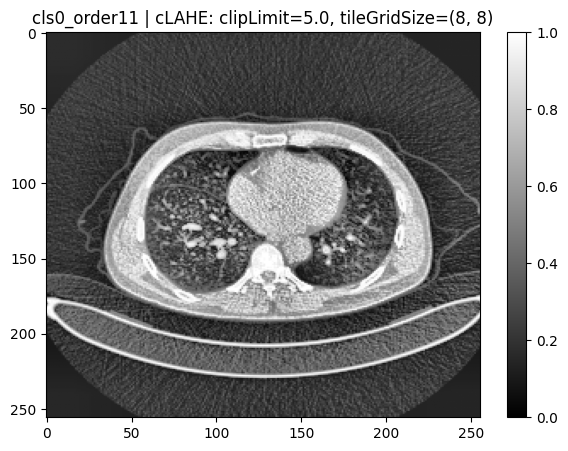

In [12]:
img_ID = "cls0_order11"
c1 = d_meta_DataPipe["img_ID"] == img_ID
img_pipe_path = d_meta_DataPipe[c1]["path_img_pipe003"].item()
print(f"Pipe output image path: \n{img_pipe_path}\n")
arr_img = np.load(img_pipe_path)
print(f"image shape: {arr_img.shape}")
print(f"image pixel value range: {arr_img.min(), arr_img.max()}\n")

#=== 
plt.figure(figsize=(7,5))
plt.imshow(arr_img, 
           cmap='gray', 
           aspect='auto', 
           # interpolation='none',
           vmin=0, vmax=1, 
          )
plt.colorbar()
plt.title(f"{img_ID} | cLAHE: clipLimit={clipLimit}, tileGridSize={tileGridSize}")